In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# internal imports
from pympc.control.hybrid_benchmark.mixed_logical_dynamical_system import MixedLogicalDynamicalSystem
from pympc.control.hybrid_benchmark.controller_mld import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory

In [40]:
# system numeric parameters
mc = 1.   # mass cart
mp = 1.   # mass pole
l  = 1.   # length pole
d  = 1.   # distance walls from origin
k  = 100. # stiffness contacts
nu = 10.  # damping contacts
g  = 10.  # gravity acceleration
h  = .05  # integration time step

# state bounds
x_max = np.array([d, np.pi/6., 7., 5.])
x_min = - x_max

# input bounds
uc_max = np.array([20.])
uc_min = - uc_max

In [41]:
# symbolic states
x = sp.Matrix(sp.symbols('q t qd td'))

# symbolic continuous inputs
uc = sp.Matrix([sp.symbols('u')])

# symbolic binary inputs
ub = sp.zeros(0,1)

# symbolic forces (left, right)
sc = sp.Matrix(sp.symbols('f_l f_r'))

# symbolic auxiliary binaries (left, right)
sb = sp.Matrix(sp.symbols('el_l dam_l el_r dam_r'))

# dynamics
x2_dot = x[1]*g*mp/mc + uc[0]/mc
x3_dot = x[1]*g*(mc+mp)/(l*mc) + uc[0]/(l*mc) + (sc[1] - sc[0])/(l*mp)
x_next = sp.Matrix([
    x[0] + h*x[2],
    x[1] + h*x[3],
    x[2] + h*x2_dot,
    x[3] + h*x3_dot
])

In [42]:
# enforce state constraints
state_upper_bound = x - x_max.reshape(x_max.size, 1)
state_lower_bound = x_min.reshape(x_min.size, 1) - x

# enforce input constraints
input_upper_bound = uc - uc_max.reshape(uc_max.size, 1)
input_lower_bound = uc_min.reshape(uc_min.size, 1) - uc

In [43]:
f = { # force
    'l': sc[0],
    'r': sc[1]
}
el = { # inidicator for penetation
    'l': sb[0],
    'r': sb[2]
}
dam = { # inidicator for pulling
    'l': sb[1],
    'r': sb[3]
}
p = { # penetration
    'l': - d - x[0] + l*x[1],
    'r': x[0] - l*x[1] - d
}
p_dot = { # relative velocity
    'l': - x[2] + l*x[3],
    'r': x[2] - l*x[3]
}
p_min = { # min penetration
    'l': - d - x_max[0] + l*x_min[1],
    'r': x_min[0] - l*x_max[1] - d
}
p_max = { # max penetration
    'l': - d - x_min[0] + l*x_max[1],
    'r': x_max[0] - l*x_min[1] - d
}
p_dot_min = { # min relative velocity
    'l': - x_max[2] + l*x_min[3],
    'r': x_min[2] - l*x_max[3]
}
p_dot_max = { # max relative velocity
    'l': - x_min[2] + l*x_max[3],
    'r': x_max[2] - l*x_min[3]
}
f_min = { # min force
    'l': k*p_min['l'] + nu*p_dot_min['l'],
    'r': k*p_min['r'] + nu*p_dot_min['r']
}
f_max = { # max force
    'l': k*p_max['l'] + nu*p_dot_max['l'],
    'r': k*p_max['r'] + nu*p_dot_max['r']
}

In [44]:
# contact constraints big-M method
contacts = []
for lr in ['l', 'r']:
    
    # el = 1 if p >= 0, el = 0 if otherwise
    contacts.append(sp.Matrix([p_min[lr] * (1. - el[lr]) - p[lr]]))
    contacts.append(sp.Matrix([p[lr] - p_max[lr] * el[lr]]))
    
    # dam = 1 if k p + nu p_dot >= 0, dam = 0 if otherwise
    contacts.append(sp.Matrix([f_min[lr] * (1. - dam[lr]) - k*p[lr] - nu*p_dot[lr]]))
    contacts.append(sp.Matrix([k*p[lr] + nu*p_dot[lr] - f_max[lr] * dam[lr]]))
    
    # el = 0 or dam = 0 implies f = 0
    contacts.append(sp.Matrix([- f[lr]]))
    contacts.append(sp.Matrix([f[lr] - f_max[lr]*el[lr]]))
    contacts.append(sp.Matrix([f[lr] - f_max[lr]*dam[lr]]))
    
    # el = dam = 1 implies f = k p + nu p_dot
    contacts.append(sp.Matrix([k*p[lr] + nu*p_dot[lr] + nu*p_dot_max[lr]*(el[lr]-1.) - f[lr]]))
    contacts.append(sp.Matrix([f[lr] - k*p[lr] - nu*p_dot[lr] - f_min[lr]*(dam[lr]-1.)]))

In [45]:
# gather constraints
constraints = sp.Matrix([
    state_upper_bound,
    state_lower_bound,
    input_upper_bound,
    input_lower_bound,
    sp.Matrix(contacts)
])

In [46]:
# construct MLD system
variables = {'x':x, 'uc':uc, 'ub':ub, 'sc':sc, 'sb':sb}
MLD = MixedLogicalDynamicalSystem.from_symbolic(variables, x_next, constraints)

In [72]:
# controller parameters
N = 50
weight_matrices = {}
weight_matrices['Q'] = 10.*np.eye(MLD.nx)*h/2.
weight_matrices['R'] = .1*np.eye(MLD.nuc)*h/2.
weight_matrices['P'] = weight_matrices['Q']#*100.

# hybrid controller
controller = HybridModelPredictiveController(MLD, N, weight_matrices)

In [73]:
x0 = np.array([0., 0., 2.5, 0.])
# x0 = np.array([0.44366632, 0.06866632, 2.94079905, 0.45738834])

# try controller open loop

In [74]:
cost, sol, leaves = controller.feedforward(x0, tree_file_name='tau_eq_0')

|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.095            1                4.508            inf             
                   3.122            43               8.809            inf             
                   6.147            82               15.348           inf             
                   9.192            120              15.547           inf             
                   12.199           158              15.575           inf             
                   15.241           196              15.673           inf             
                   18.311           235              15.793           inf             
                   21.335           273              15.845           inf             
                   24.395           311              15.858           inf             
                   27.427           344     

In [68]:
np.random.seed(1)
e_max = 0.0
e_0 = e_max * np.random.randn(MLD.nx)
x_1 = sol['primal']['x'][1] + e_0
print e_0

[ 0. -0. -0. -0.]


In [69]:
stage_variables = {
    'x_0' : sol['primal']['x'][0],
    'uc_0' : sol['primal']['uc'][0],
    'ub_0' : sol['primal']['ub'][0],
    'sc_0' : sol['primal']['sc'][0],
    'sb_0' : sol['primal']['sb'][0],
    'e_0' : e_0
}
warm_start = controller.construct_warm_start(leaves, stage_variables)

In [70]:
cost_1_ws, sol_1_ws, leaves_1_ws = controller.feedforward(x_1, tree_file_name='tau_eq_0_ws', warm_start=warm_start)

Loaded warm start with 80 nodes. Lower bound provided by the warm start is 12.181.
|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.044            1                12.311           inf             
  New incumbent    0.274            8                12.312           12.312          
  Solution found   0.310            9                12.312           12.312          

Explored 9 nodes in 0.310 seconds: optimal solution found with objective 12.312.


In [71]:
cost_1, sol_1, leaves_1 = controller.feedforward(x_1, tree_file_name='tau_eq_1')

|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.064            1                3.388            inf             
                   3.077            100              12.125           inf             
  New incumbent    4.799            160              12.312           12.312          
  Solution found   4.827            161              12.312           12.312          

Explored 161 nodes in 4.827 seconds: optimal solution found with objective 12.312.


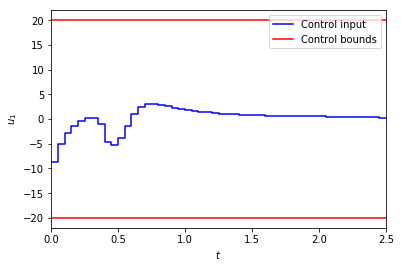

In [77]:
plot_input_sequence(sol['primal']['uc'], h, (uc_min, uc_max))
plt.savefig('input.pdf')

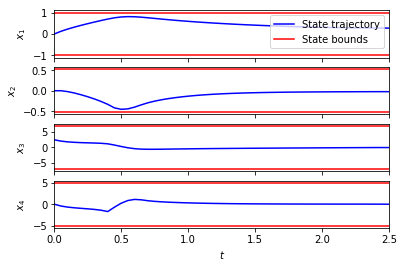

In [80]:
plot_state_trajectory(sol['primal']['x'], h, (x_min, x_max))
# plt.savefig('state.pdf')

[array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([ 0.        , 31.72429936]), array([ 0.        , 31.98832244]), array([ 0.        , 25.45065081]), array([ 0.        , 15.40459287]), array([0.        , 5.09589749]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.])]


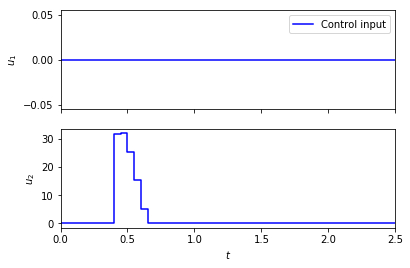

In [88]:
plot_input_sequence(sol['primal']['sc'], h)
# plt.savefig('forces.pdf')
print sol['primal']['sc']

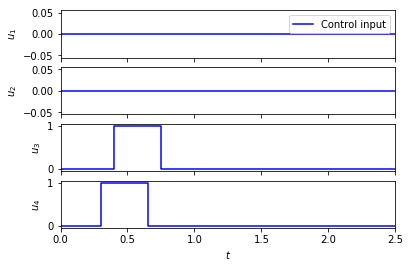

In [87]:
plot_input_sequence(sol['primal']['sb'], h)
# plt.savefig('binaries.pdf')

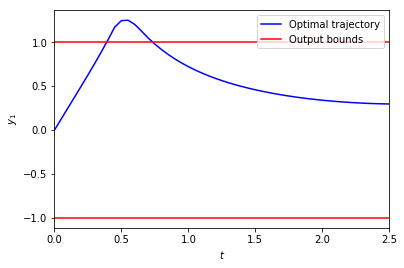

In [83]:
# output (horizontal position of the tip of the pole)
C = np.array([[1., -l, 0., 0.]])
y_min = np.array([-d])
y_max = np.array([d])
plot_output_trajectory(C, sol['primal']['x'], h, (y_min, y_max))
plt.savefig('output.pdf')

# solve in closed loop

In [ ]:
np.random.seed(1)
e_max = 0.001
N_sim = 100
u_sim = []
e_sim = []
x_sim = [x0]
warm_start = None
for t in range(N_sim):
    print('Time step ' + str(t) + '.\r'),
    cost, sol, leaves = controller.feedforward(
        x_sim[-1],
        warm_start=warm_start,
        printing_period=None,
        tree_file_name=None,
    )
    u_sim.append(sol['primal']['uc'][0])
    e_sim.append(e_max * np.random.randn(MLD.nx))
    x_sim.append(sol['primal']['x'][1] + e_sim[-1])
#     print cost
#     print len(leaves)
    
    stage_variables = {
        'x_0' : sol['primal']['x'][0],
        'uc_0' : sol['primal']['uc'][0],
        'ub_0' : sol['primal']['ub'][0],
        'sc_0' : sol['primal']['sc'][0],
        'sb_0' : sol['primal']['sb'][0],
        'e_0' : e_sim[-1]
    }
#     print e_sim[-1]
#     print x_sim[-1]
#     warm_start = controller.construct_warm_start(leaves, stage_variables)

In [ ]:
plot_input_sequence(e_sim, h, (-e_max*np.ones(MLD.nx), e_max*np.ones(MLD.nx)))
plt.show()
plot_input_sequence(u_sim, h, (u_min, u_max))
plt.show()
plot_state_trajectory(x_sim, h, (x_min, x_max))
plt.show()